In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
# Run interactively in a node

# import xarray as xr
# import glob
# import re
# import os
# import shutil
# from datetime import datetime
# from tqdm import tqdm

# def extract_datetime(filename):
#     match = re.search(r'_(\d{8}T\d{6})Z_', filename)
#     if match:
#         return datetime.strptime(match.group(1), '%Y%m%dT%H%M%S')
#     raise ValueError(f"❌ Could not parse datetime from {filename}")

# # Load coordinate templates
# lat_ds = xr.open_dataset("tempo_lat.nc")
# lon_ds = xr.open_dataset("tempo_lon.nc")

# files = sorted(glob.glob('TEMPO_NO2_L3_V03_*.nc'))
# zarr_store = 'tempo_streamed.zarr'


# # In[2]:


# import xarray as xr
# import glob
# import os
# from datetime import datetime

# # Step 1: List files (modify number or pattern as needed)
# file_list = sorted(glob.glob("TEMPO_NO2_L3_V03_*.nc"))

# # Step 2: Define a preprocess function to inject correct datetime
# def assign_correct_time(ds):
#     filename = ds.encoding['source']
#     timestamp_str = os.path.basename(filename).split('_')[4]  # e.g., '20230802T151249Z'
#     dt = datetime.strptime(timestamp_str, "%Y%m%dT%H%M%SZ")
#     return ds.assign_coords(time=("time", [dt]))

# # Step 3: Load multiple files with assigned datetimes
# ds = xr.open_mfdataset(
#     file_list,
#     combine='nested',
#     concat_dim='time',
#     chunks={'time': 100, 'latitude': 1000, 'longitude': 1000},
#     preprocess=assign_correct_time
# )
# import xarray as xr
# # Step 4: Select variable of interest (adjust if needed)
# ds = ds[['vertical_column_troposphere']]

# # Step 5: Add day-of-week coordinate
# ds = ds.assign_coords(dayofweek=ds.time.dt.dayofweek)

# # Step 6: Group and compute weekly climatology
# weekly_clim = ds.groupby('dayofweek').mean('time')

# # Step 7: Rename day indices to names (optional)
# day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekly_clim = weekly_clim.assign_coords(dayofweek=[day_names[d] for d in weekly_clim.dayofweek.values])

# # # Step 8: Save result to NetCDF
# # weekly_clim.to_netcdf("weekly_climatology.nc")
# # print("✅ Saved weekly climatology to 'weekly_climatology.nc'")


# # # In[3]:


# # weekly_clim


# # In[5]:


# # Load coordinate templates
# lat_ds = xr.open_dataset("tempo_lat.nc")
# lon_ds = xr.open_dataset("tempo_lon.nc")


# # In[6]:


# lon_ds


# # In[7]:


# import xarray as xr

# # Extract the actual coordinate values from lat_ds and lon_ds
# latitudes = lat_ds.latitude
# longitudes = lon_ds.longitude

# # Assign them as coordinates to the weekly_clim dataset
# weekly_clim = weekly_clim.assign_coords({
#     "latitude": latitudes,
#     "longitude": longitudes
# })


# # # In[9]:


# # weekly_clim


# # In[10]:


# from dask.diagnostics import ProgressBar
# import dask

# # Lazily prepare the writing
# delayed_obj = weekly_clim.to_zarr(
#     "weekly_clim.zarr",
#     mode='w',
#     compute=False,
#     consolidated=True
# )


In [2]:
import xarray as xr
weekly_clim = xr.open_zarr('weekly_clim.zarr')
weekly_clim

<xarray.Dataset> Size: 1GB
Dimensions:                      (dayofweek: 7, latitude: 2950, longitude: 7750)
Coordinates:
  * dayofweek                    (dayofweek) <U9 252B 'Monday' ... 'Sunday'
  * latitude                     (latitude) float32 12kB 14.01 14.03 ... 72.99
  * longitude                    (longitude) float32 31kB -168.0 ... -13.01
Data variables:
    vertical_column_troposphere  (dayofweek, latitude, longitude) float64 1GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

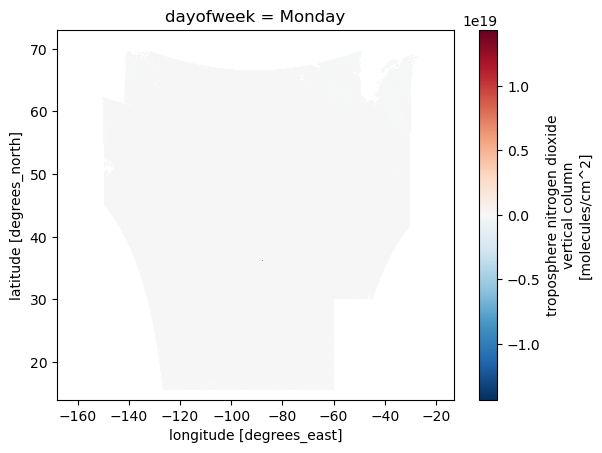

In [ ]:
weekly_clim.vertical_column_troposphere.isel(dayofweek=0).plot()

16it [00:00, 28.85it/s]


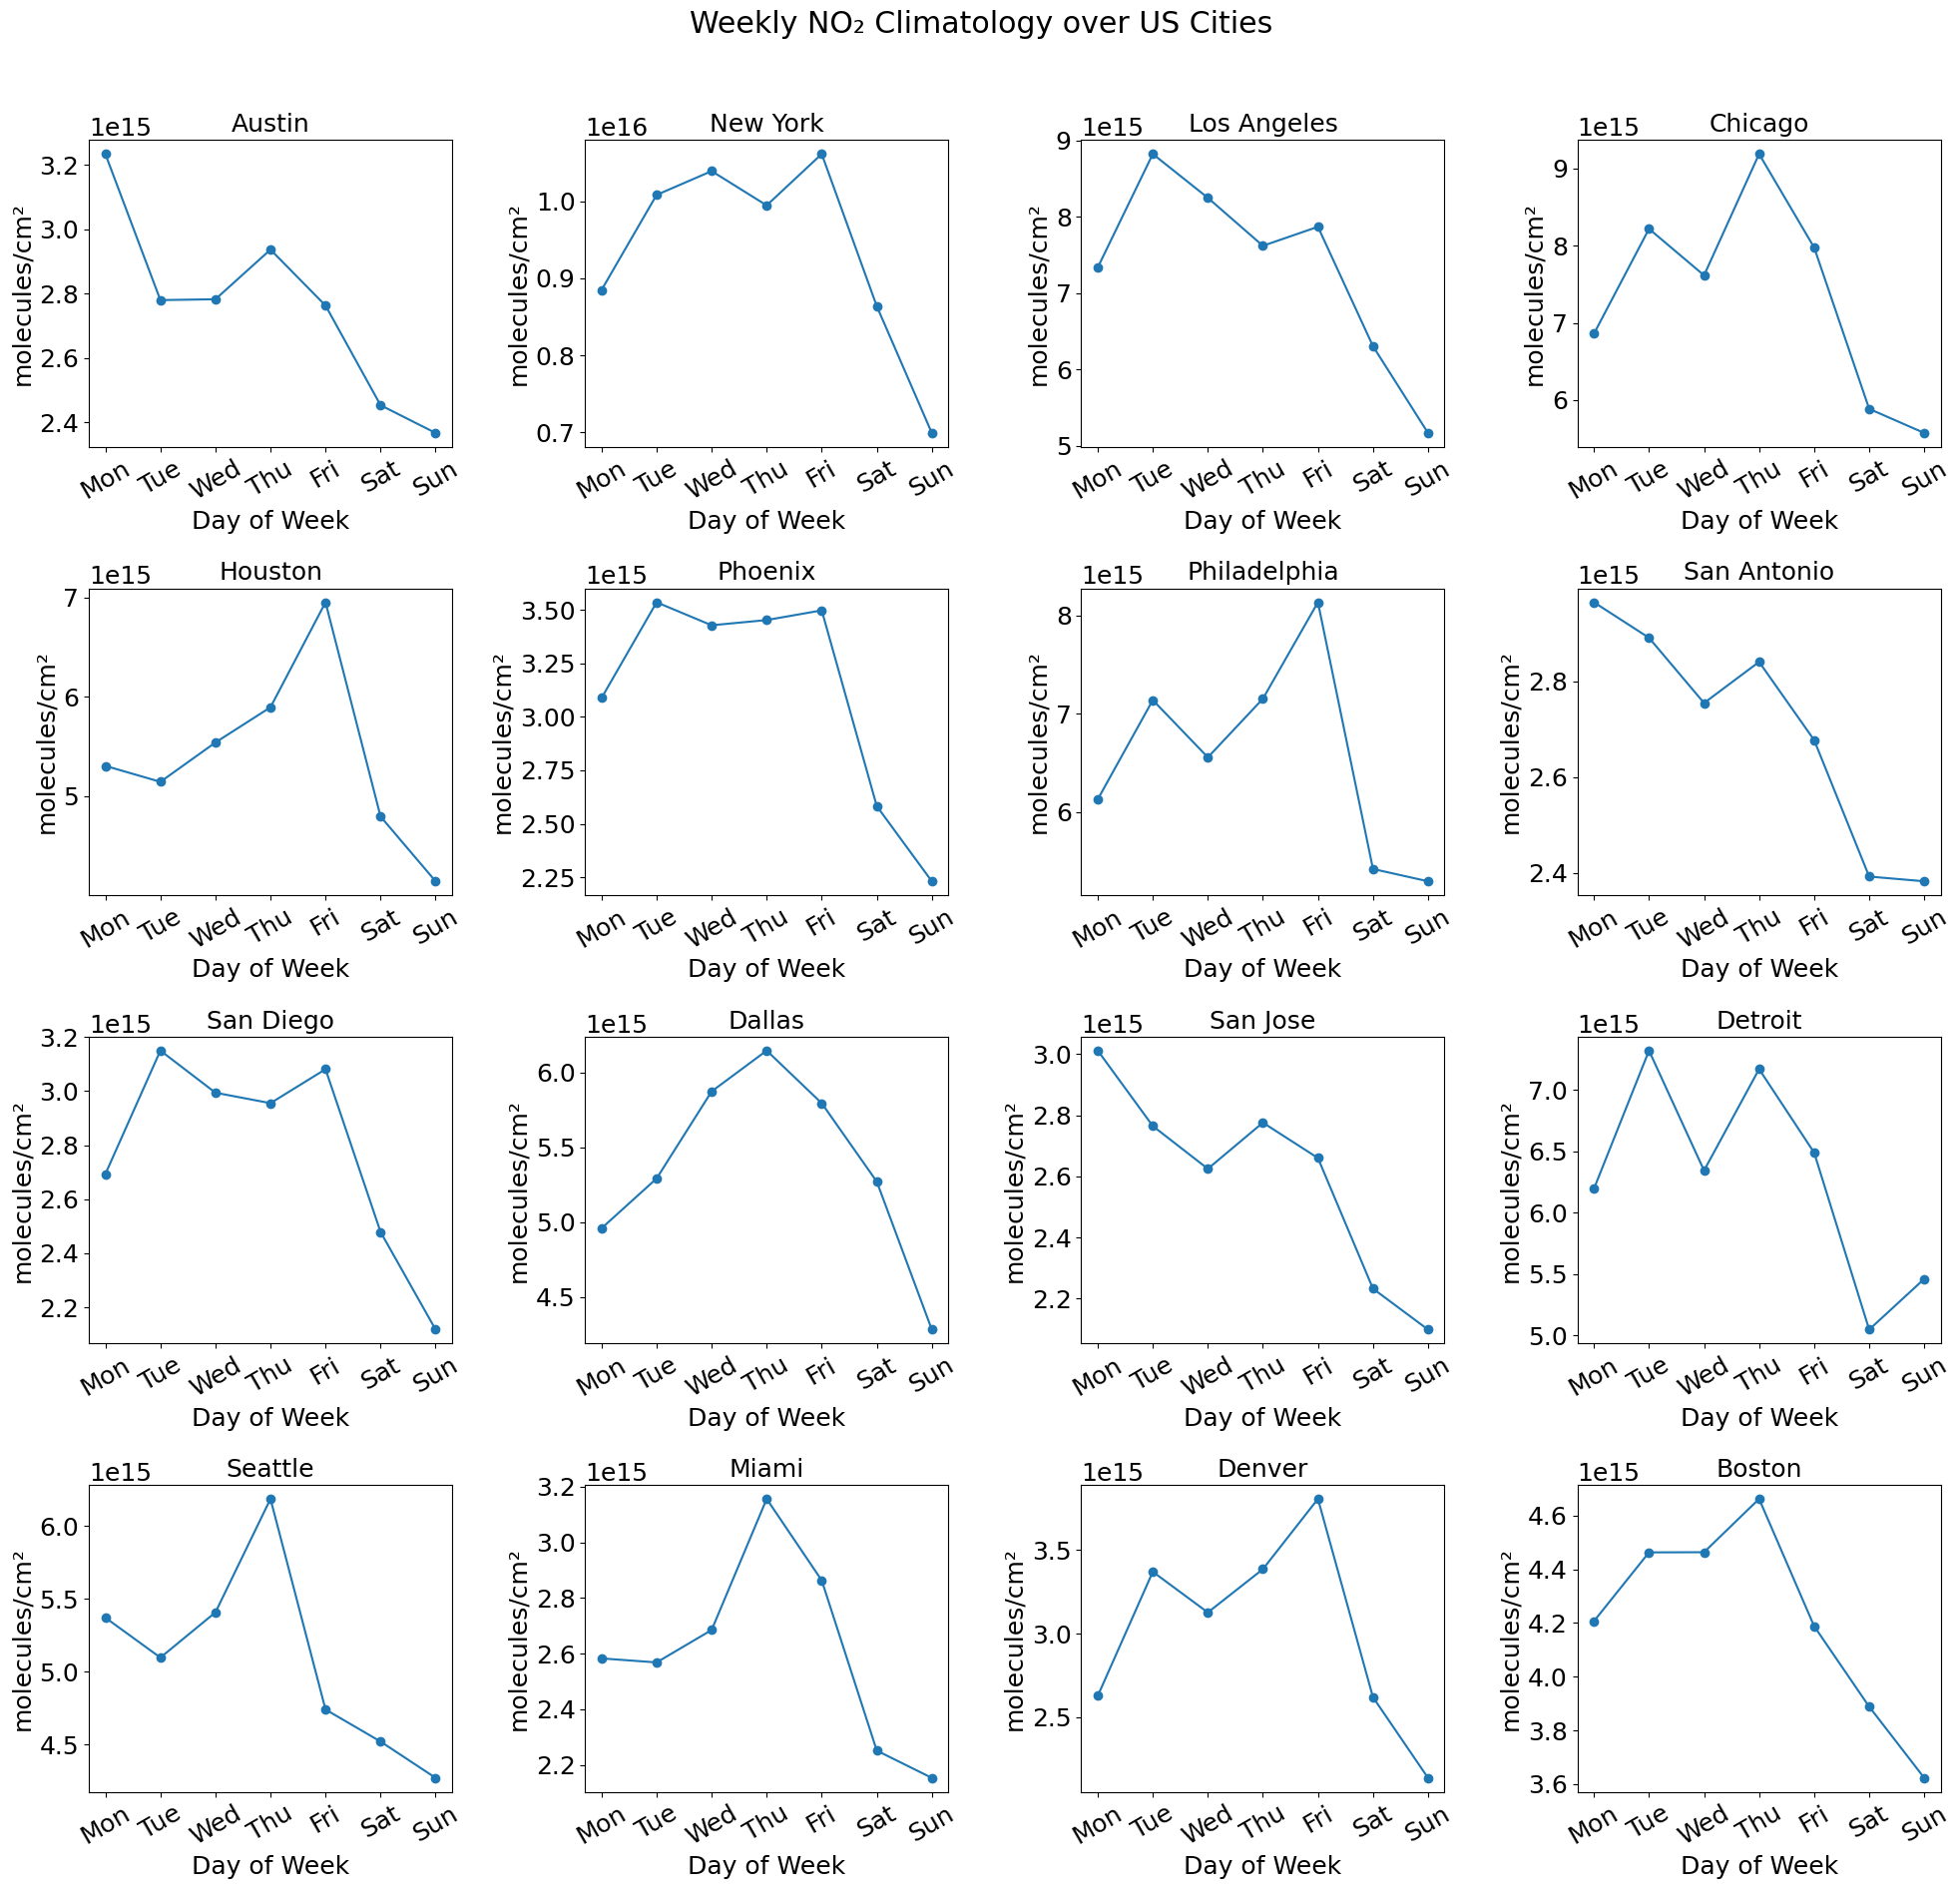

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from tqdm import tqdm

# Sample cities dictionary (same as your input)
cities = {
    "Austin": (30.2672, -97.7431),
    "New York": (40.7128, -74.0060),
    "Los Angeles": (34.0522, -118.2437),
    "Chicago": (41.8781, -87.6298),
    "Houston": (29.7604, -95.3698),
    "Phoenix": (33.4484, -112.0740),
    "Philadelphia": (39.9526, -75.1652),
    "San Antonio": (29.4241, -98.4936),
    "San Diego": (32.7157, -117.1611),
    "Dallas": (32.7767, -96.7970),
    "San Jose": (37.3382, -121.8863),
    "Detroit": (42.3314, -83.0458),
    "Seattle": (47.6062, -122.3321),
    "Miami": (25.7617, -80.1918),
    "Denver": (39.7392, -104.9903),
    "Boston": (42.3601, -71.0589)
}

# Assume weekly_clim is already loaded as an xarray.Dataset
# weekly_clim = xr.open_dataset('path_to_weekly_climatology.nc')

# Set larger font sizes
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

# Create figure with 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# Inside the plotting loop
for i, (city, (lat, lon)) in tqdm(enumerate(cities.items())):
    ds_city = weekly_clim.sel(latitude=slice(lat-0.5, lat+0.5), longitude=slice(lon-0.5, lon+0.5)).compute()
    city_mean = ds_city['vertical_column_troposphere'].mean(dim=['latitude', 'longitude'])

    # Plot
    city_mean.plot(ax=axes[i], marker='o')
    axes[i].set_title(city)
    axes[i].set_ylabel('molecules/cm²')
    axes[i].set_xlabel('Day of Week')

    # Use abbreviated day names and rotate
    short_days = [day[:3] for day in ds_city.dayofweek.values]
    axes[i].set_xticks(range(7))
    axes[i].set_xticklabels(short_days, rotation=30)
plt.suptitle('Weekly NO₂ Climatology over US Cities')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Leave space for suptitle

# Save and show
plt.savefig('us_cities_no2_weekly_climatology.png', dpi=300)
plt.show()